In [2]:
from qwak.qwak import QWAK
from utils.plotTools import searchProbStepsPlotting,searchProbStepsPlotting2

import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from math import sqrt, ceil, pow
import scipy.special as sp
import sympy as simp
import math
from qwak.State import State
from qwak.Operator import Operator
from qwak.QuantumWalk import QuantumWalk
from qwak.ProbabilityDistribution import ProbabilityDistribution
from qwak.qwak import QWAK
import copy
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.ndimage import gaussian_filter

In [3]:
def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst

def plotSearch(N,probT,tSpace,configVec):
    plotName = ""
    for T,walk,config,n in zip(tSpace,probT,configVec,N):
        #print(config)
        plt.plot(T,walk,color=config[0],linestyle=config[1],label="N=%s"%n)
        plt.vlines(max(T),0,1,color=config[0],linestyle=config[2])
        plt.legend()
        plt.xlabel("Number of steps")
        plt.ylabel("Probability of marked elements")
    for n in N:
        plotName+='_'+str(n)
    plt.savefig(r"C:\Users\jaime\Documents\GitHub\QWAK\Notebook\Output\\"+f"Search{plotName}")
    # plt.clf()
    
def plotSearch2(N,markedList, probT, tSpace, configVec,labels):
    %matplotlib inline
    plotName = ""
    fig = plt.figure()
    for T, walk, config, marked, label in zip(tSpace, probT, configVec, markedList,labels):
        plt.plot(T, walk, color=config[0], linestyle=config[1], label=label)
        plt.vlines(max(T), 0, max(probT[0]), color=config[0], linestyle=config[2])
        #plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Probability of marked elements")
    for marked in markedList:
        plotName += '_' + str(len(marked))
    return fig
    

In [4]:
n=200
t = (np.pi/2) * np.sqrt(n)
gamma = 1/n
initCond = list(range(0,n))
graph = nx.complete_graph(n)

qw = QWAK(graph=graph,gamma=gamma,markedElements=[(n//2,-1)],laplacian=False)
qw.runWalk(time=t,initStateList=initCond)
# plt.plot(qw.getProbVec(),label='CTQW')
# plt.legend()

In [5]:
def multiple_complete_qwak(N,markedElementMatrix,gamma,initCond,graph,numberOfWalks,samples):
    markedProbMatrix = []
    timeMatrix = []
    for markedElements in markedElementMatrix:
        t = (np.pi/2) * np.sqrt(N/len(markedElements))
        print(t)
        timeList = [ x for x in np.linspace(0,t,samples)]
        qw = QWAK(graph=graph,gamma=gamma,initStateList=initCond,markedElements=markedElements)
        qw.runMultipleWalks(timeList = timeList)
        solutionProbList = searchProbStepsPlotting(qw)
        markedProbMatrix.append(solutionProbList)
        timeMatrix.append(timeList)
    return timeMatrix , markedProbMatrix

In [6]:
numberOfWalks = 3
samples = 200

n = 9
N= 2**n
t = (np.pi/2) * np.sqrt(N)
timeList = [ x for x in np.linspace(0,t,samples)]
# print(timeList)
gamma = 1/N
initCond = list(range(0,N))
graph = nx.complete_graph(N)
markedElementsMatrix = [ [(x,-1) for x in range(0,N//16)], [(x,-1) for x in range(0,N//8)], [(x,-1) for x in range(0,N//4)] ]

In [7]:
timeMatrix_file = f'Datasets/CompleteSearch/timeMatrix_N{N}_NWALKS{numberOfWalks}_S{samples}.txt'
markedProbMatrix_file = f'Datasets/CompleteSearch/markedProbMatrix_N{N}_NWALKS{numberOfWalks}_S{samples}.txt'

if os.path.exists(timeMatrix_file) and os.path.exists(markedProbMatrix_file):
    timeMatrix = load_nested_list_from_file(timeMatrix_file)
    markedProbMatrix = load_nested_list_from_file(markedProbMatrix_file)
    print('File exists!')
else:
    print('File Doesnt Exist!')
    timeMatrix,markedProbMatrix = multiple_complete_qwak(N=N,markedElementMatrix = markedElements,gamma=gamma,
                                                         initCond=initCond,graph=graph,numberOfWalks = numberOfWalks, 
                                                         samples = samples)
    if not os.path.exists(timeMatrix_file):
        write_nested_list_to_file(timeMatrix_file, timeMatrix)
    if not os.path.exists(markedProbMatrix_file):
        write_nested_list_to_file(markedProbMatrix_file, markedProbMatrix)


File exists!


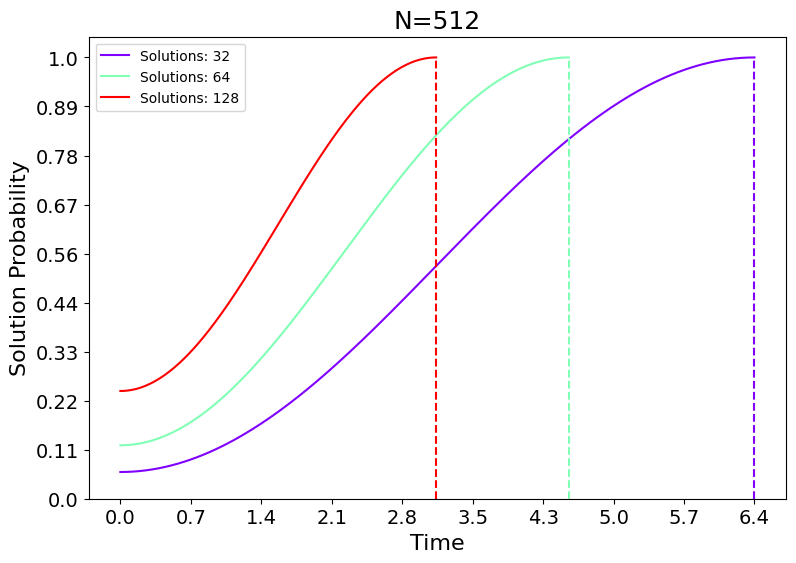

In [8]:
def plot_search(markedList, probT, tSpace, configVec, x_num_ticks=5, y_num_ticks=5, x_round_val=3, y_round_val=3, filepath=None,
                xlabel='Number of steps', ylabel='Probability of marked elements', cbar_label='Gamma', font_size=12, figsize=(8, 6),
                cbar_num_ticks=None, cbar_tick_labels=None, plot_title='Hypercube Search'):

    fig, ax = plt.subplots(figsize=figsize)

    for i, (T, walk, config, marked) in enumerate(zip(tSpace, probT, configVec, markedList)):
        max_prob = np.max(walk)
        max_prob_t = T[np.argmax(walk)]
        ax.plot(T, walk, color=config[0], linestyle=config[1], label=f'Solutions: {len(marked)}')
        ax.axvline(max_prob_t, color=config[0], linestyle='dashed', linewidth=1.5,
               ymax=max_prob/ax.get_ylim()[1])
        ax.set_xlabel(xlabel, fontsize=font_size + 2)
        ax.set_ylabel(ylabel, fontsize=font_size + 2)
        ax.set_title(plot_title, fontsize=font_size+4)

    ax.tick_params(axis='both', which='major', labelsize=font_size)

    num_t_ticks = min(y_num_ticks, len(tSpace[0]))
    t_tick_labels = np.round(np.linspace(min(tSpace[0]), max(tSpace[0]), num_t_ticks), y_round_val)

    ax.set_yticks(np.linspace(0, np.max(probT), num_t_ticks))
    ax.set_yticklabels(np.round(np.linspace(0, np.max(probT), num_t_ticks), y_round_val))

    num_x_ticks = min(x_num_ticks, len(tSpace[0]))
    x_tick_labels = np.round(np.linspace(min(tSpace[0]), max(tSpace[0]), num_x_ticks), x_round_val)

    ax.set_xticks(np.linspace(min(tSpace[0]), max(tSpace[0]), num_x_ticks))
    ax.set_xticklabels(x_tick_labels)

    ax.legend()

    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight')
        plt.show()
    else:
        plt.show()
        
colors = plt.cm.rainbow(np.linspace(0, 1, numberOfWalks))
lines = ['-']*len(timeList)
configVec = list(zip(colors,lines))

x_num_ticks=10
y_num_ticks=10
x_round_val=1
y_round_val=2

filepath=f'Output/CompleteSearch/completePlot_N{N}_NWALKS{numberOfWalks}_S{samples}.png'

plot_title = f'N={N}'

xlabel='Time'
ylabel='Solution Probability'

font_size=14
figsize=(9, 6)

plot_search(markedList=markedElementsMatrix, probT=markedProbMatrix, tSpace=timeMatrix, configVec=configVec,
            x_num_ticks=x_num_ticks, y_num_ticks=y_num_ticks, x_round_val=x_round_val, y_round_val=y_round_val, 
            filepath=filepath,xlabel=xlabel, ylabel=ylabel, font_size=font_size, 
            figsize=figsize,plot_title=plot_title)

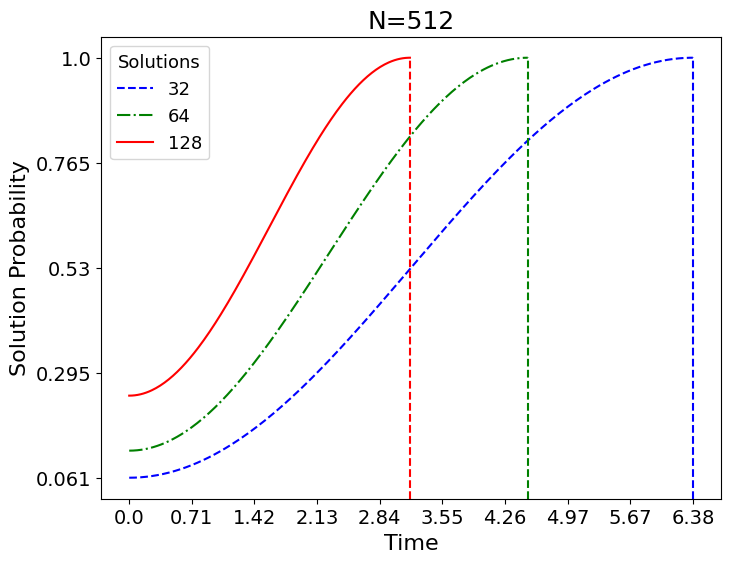

In [15]:
def plot_data(x_value_matrix, y_value_matrix, x_label=None, y_label=None, title=None, legend_labels=None, legend_title = None, legend_ncol = len(legend_labels), legend_loc='best',
              save_path=None, font_size=12, figsize=(10,6), color_list=None, line_style_list=None,
              use_loglog=False, use_cbar=False, cbar_label=None, cbar_ticks=None, cbar_tick_labels=None,
              x_num_ticks=None, y_num_ticks=None, x_round_val=3, y_round_val=3,v_line_values=None, v_line_style= '--', **kwargs):
    
    # Unpack optional parameters
    x_label = kwargs.get('x_label', x_label)
    y_label = kwargs.get('y_label', y_label)
    title = kwargs.get('title', title)
    legend_labels = kwargs.get('legend_labels', legend_labels)
    legend_title = kwargs.get('legend_title', legend_title)
    legend_ncol = kwargs.get('legend_ncol', legend_ncol)
    legend_loc = kwargs.get('legend_loc', legend_loc)
    save_path = kwargs.get('save_path', save_path)
    font_size = kwargs.get('font_size', font_size)
    figsize = kwargs.get('figsize', figsize)
    color_list = kwargs.get('color_list', color_list)
    line_style_list = kwargs.get('line_style_list', line_style_list)
    use_loglog = kwargs.get('use_loglog', use_loglog)
    use_cbar = kwargs.get('use_cbar', use_cbar)
    cbar_label = kwargs.get('cbar_label', cbar_label)
    cbar_ticks = kwargs.get('cbar_ticks', cbar_ticks)
    cbar_tick_labels = kwargs.get('cbar_tick_labels', cbar_tick_labels)
    x_num_ticks = kwargs.get('x_num_ticks', x_num_ticks)
    y_num_ticks = kwargs.get('y_num_ticks', y_num_ticks)
    x_round_val = kwargs.get('x_round_val', x_round_val)
    y_round_val = kwargs.get('y_round_val', y_round_val)
    v_line_values = kwargs.get('v_line_values', v_line_values)
    v_line_style = kwargs.get('v_line_style', v_line_style)
    
    # plot the data for each row of the data matrix
    fig, ax = plt.subplots(figsize=figsize)
    if use_loglog:
        ax.loglog()
    # ax.set_xlim([x_values[0], x_values[-1]])
    i = 0
    for xvalues,yvalues in zip(x_value_matrix,y_value_matrix):
        color = None
        line_style = None
        label = None
        if color_list is not None:
            color = color_list[i]
        if line_style_list is not None:
            line_style = line_style_list[i]
        if legend_labels is not None:
            label = legend_labels[i]
        ax.plot(xvalues, yvalues, label=label,
                color=color, linestyle=line_style)
        if v_line_values is not None:
            ax.axvline(x = v_line_values[i][0],ymin = 0, ymax = v_line_values[i][1]/ax.get_ylim()[1] , color=color, linestyle=v_line_style, linewidth=1.5)
        i+=1

    # set the axis labels
    if x_label is not None:
        ax.set_xlabel(x_label, fontsize=font_size+2)
    if y_label is not None:
        ax.set_ylabel(y_label, fontsize=font_size+2)

    # set the plot title
    if title is not None:
        ax.set_title(title, fontsize=font_size+4)

    # set the legend
    if legend_labels is not None:
        legend = ax.legend(loc=legend_loc,ncol=legend_ncol, fontsize=font_size-1)
        if legend_title is not None:
            legend.set_title(legend_title, prop={'size': font_size - 1})

    # set font size for ticks
    ax.tick_params(axis='both', labelsize=font_size)

    # set tick labels
    if x_num_ticks is not None:
        num_x_ticks = min(x_num_ticks, len(x_value_matrix[0]))
        x_tick_labels = np.round(np.linspace(np.min(x_value_matrix), np.max(x_value_matrix), num_x_ticks), x_round_val)
        ax.set_xticks(np.linspace(np.min(x_value_matrix), np.max(x_value_matrix), num_x_ticks))
        ax.set_xticklabels(x_tick_labels)
    
    if y_num_ticks is not None:
        num_y_ticks = min(y_num_ticks, len(y_value_matrix[1]))
        y_tick_labels = np.round(np.linspace(np.min(y_value_matrix),np.max(y_value_matrix), num_y_ticks), y_round_val)
        ax.set_yticks(np.linspace(np.min(y_value_matrix), np.max(y_value_matrix), num_y_ticks))
        ax.set_yticklabels(y_tick_labels)

    # add colorbar
    if use_cbar:
        colors = color_list or ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=len(colors))
        norm = BoundaryNorm(y_value_matrix, len(y_value_matrix)-1)

        if cbar_ticks is None:
            cbar_ticks = data_matrix

        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=cbar_ticks)
        if cbar_label is not None:
            cbar.set_label(cbar_label, fontsize=font_size + 2)
        cbar.ax.tick_params(labelsize=font_size)

    if cbar_tick_labels is not None:
        cbar.ax.set_yticklabels(cbar_tick_labels)

    # save or show the plot
    if save_path is not None:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()

filepath=f'Output/CompleteSearch/completePlot_N{N}_NWALKS{numberOfWalks}_S{samples}.png'

font_size = 14
figsize=(8, 6)

plot_title = f'N={N}'
xlabel='Time'
ylabel='Solution Probability'

legend_labels = []
for marked in markedElementsMatrix:
    legend_labels.append(f'{len(marked)}')

legend_loc = "best"
legend_title = 'Solutions'
legend_ncol = 1

color_list = ['b','g','r']
line_style_list = ['--', '-.','-' ]

use_loglog = False
use_cbar = False
cbar_label = None 
cbar_ticks = None
cbar_tick_labels = None
x_num_ticks = 10
y_num_ticks = 5
x_round_val = 2
y_round_val = 3

v_line_values = []

for T, walk in zip(timeMatrix, markedProbMatrix):
    v_line_values.append((T[np.argmax(walk)],np.max(walk)))
        
plot_data(x_value_matrix = timeMatrix, y_value_matrix = markedProbMatrix, x_label=xlabel, y_label=ylabel, title=plot_title, legend_labels=legend_labels, legend_title = legend_title, 
          legend_ncol = legend_ncol, legend_loc=legend_loc, save_path=filepath, font_size=font_size, figsize=figsize, color_list=color_list, line_style_list=line_style_list,
          use_loglog=use_loglog, use_cbar=use_cbar, cbar_label=cbar_label, cbar_ticks=cbar_ticks, cbar_tick_labels=cbar_tick_labels,
          x_num_ticks=x_num_ticks, y_num_ticks=y_num_ticks, x_round_val=x_round_val, y_round_val=y_round_val,v_line_values=v_line_values)

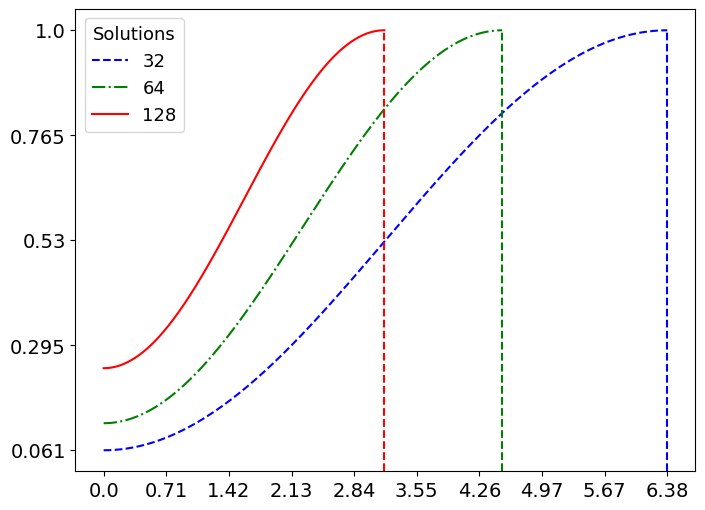

In [16]:
def plot_data(x_value_matrix, y_value_matrix, x_label=None, y_label=None, title=None, legend_labels=None, legend_title = None, legend_ncol = len(legend_labels), legend_loc='best',
              save_path=None, font_size=12, figsize=(10,6), color_list=None, line_style_list=None,
              use_loglog=False, use_cbar=False, cbar_label=None, cbar_ticks=None, cbar_tick_labels=None,
              x_num_ticks=None, y_num_ticks=None, x_round_val=3, y_round_val=3,v_line_values=None, v_line_style= '--', **kwargs):
    
    # Unpack optional parameters
    x_label = kwargs.get('x_label', x_label)
    y_label = kwargs.get('y_label', y_label)
    title = kwargs.get('title', title)
    legend_labels = kwargs.get('legend_labels', legend_labels)
    legend_title = kwargs.get('legend_title', legend_title)
    legend_ncol = kwargs.get('legend_ncol', legend_ncol)
    legend_loc = kwargs.get('legend_loc', legend_loc)
    save_path = kwargs.get('save_path', save_path)
    font_size = kwargs.get('font_size', font_size)
    figsize = kwargs.get('figsize', figsize)
    color_list = kwargs.get('color_list', color_list)
    line_style_list = kwargs.get('line_style_list', line_style_list)
    use_loglog = kwargs.get('use_loglog', use_loglog)
    use_cbar = kwargs.get('use_cbar', use_cbar)
    cbar_label = kwargs.get('cbar_label', cbar_label)
    cbar_ticks = kwargs.get('cbar_ticks', cbar_ticks)
    cbar_tick_labels = kwargs.get('cbar_tick_labels', cbar_tick_labels)
    x_num_ticks = kwargs.get('x_num_ticks', x_num_ticks)
    y_num_ticks = kwargs.get('y_num_ticks', y_num_ticks)
    x_round_val = kwargs.get('x_round_val', x_round_val)
    y_round_val = kwargs.get('y_round_val', y_round_val)
    v_line_values = kwargs.get('v_line_values', v_line_values)
    v_line_style = kwargs.get('v_line_style', v_line_style)
    
    # plot the data for each row of the data matrix
    fig, ax = plt.subplots(figsize=figsize)
    if use_loglog:
        ax.loglog()
    # ax.set_xlim([x_values[0], x_values[-1]])
    i = 0
    for xvalues,yvalues in zip(x_value_matrix,y_value_matrix):
        color = None
        line_style = None
        label = None
        if color_list is not None:
            color = color_list[i]
        if line_style_list is not None:
            line_style = line_style_list[i]
        if legend_labels is not None:
            label = legend_labels[i]
        ax.plot(xvalues, yvalues, label=label,
                color=color, linestyle=line_style)
        if v_line_values is not None:
            ax.axvline(x = v_line_values[i][0],ymin = 0, ymax = v_line_values[i][1]/ax.get_ylim()[1] , color=color, linestyle=v_line_style, linewidth=1.5)
        i+=1

    # set the axis labels
    if x_label is not None:
        ax.set_xlabel(x_label, fontsize=font_size+2)
    if y_label is not None:
        ax.set_ylabel(y_label, fontsize=font_size+2)

    # set the plot title
    if title is not None:
        ax.set_title(title, fontsize=font_size+4)

    # set the legend
    if legend_labels is not None:
        legend = ax.legend(loc=legend_loc,ncol=legend_ncol, fontsize=font_size-1)
        if legend_title is not None:
            legend.set_title(legend_title, prop={'size': font_size - 1})

    # set font size for ticks
    ax.tick_params(axis='both', labelsize=font_size)

    # set tick labels
    if x_num_ticks is not None:
        num_x_ticks = min(x_num_ticks, len(x_value_matrix[0]))
        x_tick_labels = np.round(np.linspace(np.min(x_value_matrix), np.max(x_value_matrix), num_x_ticks), x_round_val)
        ax.set_xticks(np.linspace(np.min(x_value_matrix), np.max(x_value_matrix), num_x_ticks))
        ax.set_xticklabels(x_tick_labels)
    
    if y_num_ticks is not None:
        num_y_ticks = min(y_num_ticks, len(y_value_matrix[1]))
        y_tick_labels = np.round(np.linspace(np.min(y_value_matrix),np.max(y_value_matrix), num_y_ticks), y_round_val)
        ax.set_yticks(np.linspace(np.min(y_value_matrix), np.max(y_value_matrix), num_y_ticks))
        ax.set_yticklabels(y_tick_labels)

    # add colorbar
    if use_cbar:
        colors = color_list or ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=len(colors))
        norm = BoundaryNorm(y_value_matrix, len(y_value_matrix)-1)

        if cbar_ticks is None:
            cbar_ticks = data_matrix

        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=cbar_ticks)
        if cbar_label is not None:
            cbar.set_label(cbar_label, fontsize=font_size + 2)
        cbar.ax.tick_params(labelsize=font_size)

    if cbar_tick_labels is not None:
        cbar.ax.set_yticklabels(cbar_tick_labels)

    # save or show the plot
    if save_path is not None:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()
        
legend_labels = []
for marked in markedElementsMatrix:
    legend_labels.append(f'{len(marked)}')

v_line_values = []
for T, walk in zip(timeMatrix, markedProbMatrix):
    v_line_values.append((T[np.argmax(walk)],np.max(walk)))
    
params = {
    'font_size' : 14,
    'figsize': (8, 6),
    'plot_title' : f'N={N}',
    'xlabel' : 'Time',
    'ylabel' : 'Solution Probability',
    'legend_labels' : legend_labels,
    'legend_loc': 'best',
    'legend_title' : 'Solutions',
    'legend_ncol' : 1,
    'color_list' : ['b','g','r'],
    'line_style_list' : ['--', '-.','-' ],
    'filepath' : f'Output/CompleteSearch/completePlot_N{N}_NWALKS{numberOfWalks}_S{samples}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_num_ticks' : 10,
    'y_num_ticks' : 5,
    'x_round_val' : 2,
    'y_round_val' : 3,
    'v_line_values' : v_line_values,
    'v_line_style': '--'
}


plot_data(x_value_matrix = timeMatrix, y_value_matrix = markedProbMatrix,**params)